# Temporal-Difference Methods

### Explore CliffWalkingEnv

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [1]:
import gym
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [2]:
from collections import defaultdict
import sys
import numpy as np
from plot_utils import plot_values
import matplotlib.pyplot as plt

### TD Prediction: State Values

We will begin by investigating a policy where the agent moves:
- `RIGHT` in states `0` through `10`, inclusive,  
- `DOWN` in states `11`, `23`, and `35`, and
- `UP` in states `12` through `22`, inclusive, states `24` through `34`, inclusive, and state `36`.

In [ ]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))

Run the next cell to visualize the state-value function that corresponds to this policy.

In [ ]:
V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

plot_values(V_true)

TD prediction has five arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `policy`: This is a 1D numpy array with `policy.shape` equal to the number of states (`env.nS`).  `policy[s]` returns the action that the agent chooses when in state `s`.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.

In [ ]:
def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    # initialize empty dictionaries of floats
    V = defaultdict(float)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    
        state = env.reset()
        while True:
            action = policy[state]
            next_state, reward, done, info = env.step(action)
            V[state] += alpha*(reward + gamma*V[next_state] - V[state])
            state = next_state
            if done:
                break
    
    return V 

In [ ]:
# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)

V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
plot_values(V_pred_plot)

How close is your estimated state-value function to the true state-value function corresponding to the policy?  

You might notice that some of the state values are not estimated by the agent.  This is because under this policy, the agent will not visit all of the states.  In the TD prediction algorithm, the agent can only estimate the values corresponding to states that are visited.

### TD Control: Sarsa

The Sarsa algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `fixedEpsilon`: defaults to False; should epsilon decay over time

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [3]:
def e_greedy_policy_creation(Qstate, epsilon, nA):
    """
    Q: Our Q table. 
      Q[state] = numpy.array
      Q[state][action] = float.
    epsilon: small value that controls exploration.
    nA: the number of actions available in this environment
    
    return: an epsilon-greedy policy specific to the state.
    """
    
    policy = np.ones(nA) * epsilon/nA
    policy[np.argmax(Qstate)] = 1 - epsilon + (epsilon / env.nA)        
    return policy

In [4]:
def choose_action(policy, env):
    return np.random.choice(np.arange(env.nA), p=policy)

In [5]:
def sarsa(env, num_episodes, alpha, gamma=1.0, fixedEpsilon = False):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes

    for i_episode in range(1, num_episodes+1):        
        state = env.reset()
        #To see the policy from the book, keep epsilon fixed at 0.1
        epsilon = 0.1 if fixedEpsilon else 1.0 / i_episode
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        done = False
        policy = e_greedy_policy_creation(Q[state], epsilon, env.nA)    
        action = choose_action(policy, env)
        while not done:
            sPrime, reward, done, info = env.step(action)
            policySPrime = e_greedy_policy_creation(Q[sPrime], epsilon, env.nA)
            aPrime = choose_action(policySPrime, env)
            Q[state][action] += alpha * (reward + (gamma * Q[sPrime][aPrime]) - Q[state][action])
            state, action = sPrime, aPrime
    return Q

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

As noted in S&B, with a decaying epsilon, Sarsa finds the knife-edge optimal policy!

### TD Control: Q-learning

The Q-Learning algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes

    for i_episode in range(1, num_episodes+1):        
        state = env.reset()
        epsilon = 1.0 / i_episode
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        done = False
        policy = e_greedy_policy_creation(Q[state], epsilon, env.nA)    
        while not done:
            action = choose_action(policy, env)
            sPrime, reward, done, info = env.step(action)
            policy = e_greedy_policy_creation(Q[sPrime], epsilon, env.nA)
            Q[state][action] += alpha * (reward + (gamma * np.max(Q[sPrime])) - Q[state][action])
            state = sPrime
    return Q

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

As we can clearly see here, we have found the cliff/knife-edge optimal policy. 

### TD Control: Expected Sarsa

The Expected Sarsa algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes

    for i_episode in range(1, num_episodes+1):        
        state = env.reset()
        epsilon = 1.0 / i_episode
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        done = False
        policy = e_greedy_policy_creation(Q[state], epsilon, env.nA)    
        while not done:
            action = choose_action(policy, env)
            sPrime, reward, done, info = env.step(action)
            policy = e_greedy_policy_creation(Q[sPrime], epsilon, env.nA) 
            Q[state][action] += alpha * (reward + (gamma * np.dot(Q[sPrime], policy)) - Q[state][action])
            state = sPrime
    return Q

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 0.01)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

----

Let us return to Sarsa, but instead use a fixed epsilon. When we do this, we will find that we will recreate the figure from the book: 

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 10000, .01, fixedEpsilon=True)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

While this policy is not exactly the same as the one in the book, it illustrates the same concept. Our agent has learned to take safer actions by first going up to the second-to-the-top row before moving across the cliff wall. By constantly being forced to explore its surroundings, the Agent cannot walk the knife-edge policy or it risks taking an explore step that kills the agent. 

----

Sarsa and Q-Learning behave different for the same initial conditions based on how they work. Since Q-learning simply takes the max of the available next options as the value for the current state, it is working off-policy. Whereas, with Sarsa we are still inexorably tied with our simulation of the env and the policy we are currently working off of. 

However, as shown above, when we let epsilon decay over time, both Sarsa, Q-learning, and ExpectedSarsa will converge to the optimal policy.

## Double Q learning

In [10]:
def double_q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    Q2 = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes

    for i_episode in range(1, num_episodes+1):        
        state = env.reset()
        epsilon = 1.0 / i_episode
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        done = False
        policy = e_greedy_policy_creation(Q[state] + Q2[state], epsilon, env.nA)    
        while not done:
            action = choose_action(policy, env)
            sPrime, reward, done, info = env.step(action)
            policy = e_greedy_policy_creation(Q[sPrime] + Q2[sPrime], epsilon, env.nA)
            if np.random.rand() < 0.5:
                Q[state][action] += alpha * (reward + (gamma * np.max(Q2[sPrime])) - Q[state][action])
            else:
                Q2[state][action] += alpha * (reward + (gamma * np.max(Q[sPrime])) - Q2[state][action])
            state = sPrime
    finalQ = {s: Q[s] + Q2[s] for s in Q.keys()}
    return finalQ

Episode 5000/5000
Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  2  3  1  1  0  2  2  1  2  2]
 [ 1  0  0  1  1  2  1  1  1  3  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


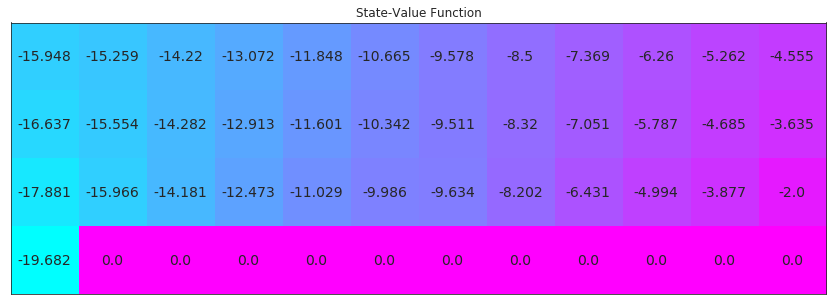

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
double_Q = double_q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_double_Q = np.array([np.argmax(double_Q[key]) if key in double_Q else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_double_Q)

# plot the estimated optimal state-value function
plot_values([np.max(double_Q[key]) if key in double_Q else 0 for key in np.arange(48)])


A future extension could be adding in a TD($\lambda$) method/n-step method.